# Import

In [26]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor
torch.cuda.empty_cache()
import math
import numpy as np

import scipy
import os
from torchvision.transforms import Compose, Resize, ToTensor
from einops import rearrange, reduce, repeat
from einops.layers.torch import Rearrange, Reduce
import matplotlib.pyplot as plt
from IPython.display import clear_output
import random
%matplotlib inline

# Modèle

In [27]:
# Définition des classes du modèle (comme dans votre code)
class Generator(nn.Module):
    def __init__(self, seq_len=64, patch_size=24, channels=1, num_classes=9, latent_dim=100, embed_dim=10, depth=3,
                 num_heads=5, forward_drop_rate=0.5, attn_drop_rate=0.5):
        super(Generator, self).__init__()
        self.channels = channels
        self.latent_dim = latent_dim
        self.seq_len = seq_len
        self.embed_dim = embed_dim
        self.patch_size = patch_size
        self.depth = depth
        self.attn_drop_rate = attn_drop_rate
        self.forward_drop_rate = forward_drop_rate

        self.l1 = nn.Linear(self.latent_dim, self.seq_len * self.embed_dim)
        self.pos_embed = nn.Parameter(torch.zeros(1, self.seq_len, self.embed_dim))
        self.blocks = Gen_TransformerEncoder(
            depth=self.depth,
            emb_size=self.embed_dim,
            drop_p=self.attn_drop_rate,
            forward_drop_p=self.forward_drop_rate
        )

        self.deconv = nn.Sequential(
            nn.Conv2d(self.embed_dim, self.channels, 1, 1, 0)
        )

    def forward(self, z):
        x = self.l1(z).view(-1, self.seq_len, self.embed_dim)
        x = x + self.pos_embed
        H, W = 1, self.seq_len
        x = self.blocks(x)
        x = x.reshape(x.shape[0], 1, x.shape[1], x.shape[2])
        output = self.deconv(x.permute(0, 3, 1, 2))
        output = output.view(-1, self.channels, H, W)
        return output


class Gen_TransformerEncoderBlock(nn.Sequential):
    def __init__(self,
                 emb_size,
                 num_heads=5,
                 drop_p=0.5,
                 forward_expansion=4,
                 forward_drop_p=0.5):
        super().__init__(
            ResidualAdd(nn.Sequential(
                nn.LayerNorm(emb_size),
                MultiHeadAttention(emb_size, num_heads, drop_p),
                nn.Dropout(drop_p)
            )),
            ResidualAdd(nn.Sequential(
                nn.LayerNorm(emb_size),
                FeedForwardBlock(
                    emb_size, expansion=forward_expansion, drop_p=forward_drop_p),
                nn.Dropout(drop_p)
            )
            ))


class Gen_TransformerEncoder(nn.Sequential):
    def __init__(self, depth=8, **kwargs):
        super().__init__(*[Gen_TransformerEncoderBlock(**kwargs) for _ in range(depth)])


class MultiHeadAttention(nn.Module):
    def __init__(self, emb_size, num_heads, dropout):
        super().__init__()
        self.emb_size = emb_size
        self.num_heads = num_heads
        self.keys = nn.Linear(emb_size, emb_size)
        self.queries = nn.Linear(emb_size, emb_size)
        self.values = nn.Linear(emb_size, emb_size)
        self.att_drop = nn.Dropout(dropout)
        self.projection = nn.Linear(emb_size, emb_size)

    def forward(self, x: Tensor, mask: Tensor = None) -> Tensor:
        queries = rearrange(self.queries(x), "b n (h d) -> b h n d", h=self.num_heads)
        keys = rearrange(self.keys(x), "b n (h d) -> b h n d", h=self.num_heads)
        values = rearrange(self.values(x), "b n (h d) -> b h n d", h=self.num_heads)
        energy = torch.einsum('bhqd, bhkd -> bhqk', queries, keys)  # batch, num_heads, query_len, key_len
        if mask is not None:
            fill_value = torch.finfo(torch.float32).min
            energy.mask_fill(~mask, fill_value)

        scaling = self.emb_size ** (1 / 2)
        att = F.softmax(energy / scaling, dim=-1)
        att = self.att_drop(att)
        out = torch.einsum('bhal, bhlv -> bhav ', att, values)
        out = rearrange(out, "b h n d -> b n (h d)")
        out = self.projection(out)
        return out


class ResidualAdd(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, **kwargs):
        res = x
        x = self.fn(x, **kwargs)
        x += res
        return x


class FeedForwardBlock(nn.Sequential):
    def __init__(self, emb_size, expansion, drop_p):
        super().__init__(
            nn.Linear(emb_size, expansion * emb_size),
            nn.GELU(),
            nn.Dropout(drop_p),
            nn.Linear(expansion * emb_size, emb_size),
        )


class Dis_TransformerEncoderBlock(nn.Sequential):
    def __init__(self,
                 emb_size=100,
                 num_heads=5,
                 drop_p=0.,
                 forward_expansion=4,
                 forward_drop_p=0.):
        super().__init__(
            ResidualAdd(nn.Sequential(
                nn.LayerNorm(emb_size),
                MultiHeadAttention(emb_size, num_heads, drop_p),
                nn.Dropout(drop_p)
            )),
            ResidualAdd(nn.Sequential(
                nn.LayerNorm(emb_size),
                FeedForwardBlock(
                    emb_size, expansion=forward_expansion, drop_p=forward_drop_p),
                nn.Dropout(drop_p)
            )
            ))


class Dis_TransformerEncoder(nn.Sequential):
    def __init__(self, depth=8, **kwargs):
        super().__init__(*[Dis_TransformerEncoderBlock(**kwargs) for _ in range(depth)])


class ClassificationHead(nn.Sequential):
    def __init__(self, emb_size=100, n_classes=1):
        super().__init__()
        self.clshead = nn.Sequential(
            Reduce('b n e -> b e', reduction='mean'),
            nn.LayerNorm(emb_size),
            nn.Linear(emb_size, n_classes)
        )

    def forward(self, x):
        out = self.clshead(x)
        return out


class PatchEmbedding_Linear(nn.Module):
    def __init__(self, in_channels=1, patch_size=16, emb_size=100, seq_length=1024):
        super().__init__()
        self.projection = nn.Sequential(
            Rearrange('b c (h s1) (w s2) -> b (h w) (s1 s2 c)', s1=1, s2=patch_size),
            nn.Linear(patch_size * in_channels, emb_size)
        )
        self.cls_token = nn.Parameter(torch.randn(1, 1, emb_size))
        self.positions = nn.Parameter(torch.randn((seq_length // patch_size) + 1, emb_size))

    def forward(self, x: Tensor) -> Tensor:
        b, _, _, _ = x.shape
        x = self.projection(x)
        cls_tokens = repeat(self.cls_token, '() n e -> b n e', b=b)
        x = torch.cat([cls_tokens, x], dim=1)
        x += self.positions
        return x


class Discriminator(nn.Sequential):
    def __init__(self,
                 in_channels=1,
                 patch_size=24,
                 emb_size=50,
                 seq_length=24,
                 depth=3,
                 n_classes=1,
                 **kwargs):
        super().__init__(
            PatchEmbedding_Linear(in_channels, patch_size, emb_size, seq_length),
            Dis_TransformerEncoder(depth, emb_size=emb_size, drop_p=0.5, forward_drop_p=0.5, **kwargs),
            ClassificationHead(emb_size, n_classes)
        )

# Config

In [28]:
# Configuration du dispositif (CPU ou GPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

cuda


# Initialisation

In [93]:
# Paramètres d'entraînement
num_epochs = 10000
batch_size = 16
num_batches = 1191 // batch_size
seq_len = 16*50
patch_size = 16
latent_dim = 100
nb_channels = 2
noise = 0.5

In [94]:
# Instanciation du générateur et du discriminateur
generator = Generator(seq_len=seq_len, 
                      patch_size=patch_size,
                      channels=nb_channels,
                      latent_dim=latent_dim,
                      ).to(device)
discriminator = Discriminator(in_channels=nb_channels,
                              patch_size=patch_size,
                              emb_size=50,
                              seq_length=seq_len).to(device)

In [95]:
# Variables pour stocker les pertes au fil des époques
losses_D = []
losses_G = []

In [96]:
# Définition de la fonction de perte et des optimiseurs
criterion = nn.BCEWithLogitsLoss()
optimizer_G = torch.optim.Adam(generator.parameters(), lr=0.0001, betas=(0.9, 0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=0.0003, betas=(0.9, 0.999))

# Génération Data

In [97]:
def get_data_from_file(filepath, seq_len):
    data = scipy.io.loadmat(filepath)
    return data['voltage'][0][:seq_len].astype(np.float64), data['current'][0][:seq_len].astype(np.float64), data['f1'][0][:seq_len].astype(np.float64), data['f2'][0][:seq_len].astype(np.float64), data['f3'][0][:seq_len].astype(np.float64)


# Fonction pour normaliser les signaux
# Problèmes avec cette normalisation : Elle est local et non global sur l'ensemble des signaux
def normalize_data(list_data):

    normalize_data_list = []

    for data in list_data:
        min_signal = np.min(data)
        max_signal = np.max(data)
        normalize_data_list.append((data - min_signal) / (max_signal - min_signal))
    
    return normalize_data_list


def generate_data(dossier, seq_len=1900, nb_channel=5, noise=10):

    data = []
    
    for file in os.listdir(dossier):
        filepath = os.path.join(dossier, file)
        if os.path.isfile(filepath):
            data_v, data_c, data_f1, data_f2, data_f3 = get_data_from_file(filepath, seq_len)
            list_data_from_file = [data_v, data_c]

            list_data_from_file = normalize_data(list_data_from_file)

            for data_from_file in list_data_from_file:
                data_from_file += np.random.normal(0, noise, data_from_file.shape)

            data.append(list_data_from_file)
    

    random.shuffle(data)

    nb_files = len(data)
    return np.array(data).reshape(nb_files, nb_channel, 1, seq_len)

def affichage_data(signal, seq_len=1900, nb_channels=5):
    # Diviser le plot en 5 parties
    fig, axs = plt.subplots(nb_channels, 1, figsize=(12, 10), sharex=True)

    # Affichage du signal réel
    for i in range(nb_channels):
        axs[i].plot(signal[np.random.randint(0, signal.shape[0])][i].reshape(seq_len), label=f'Signal réel {i+1}')
        axs[i].grid()
    
    plt.suptitle("Signal")
    plt.show()


In [98]:
folder_path = "Cluster Signaux/phase_sinus"

data_echantillon = generate_data(folder_path, seq_len, nb_channel=nb_channels, noise=noise)

In [99]:
data_echantillon.shape

(1978, 2, 1, 800)

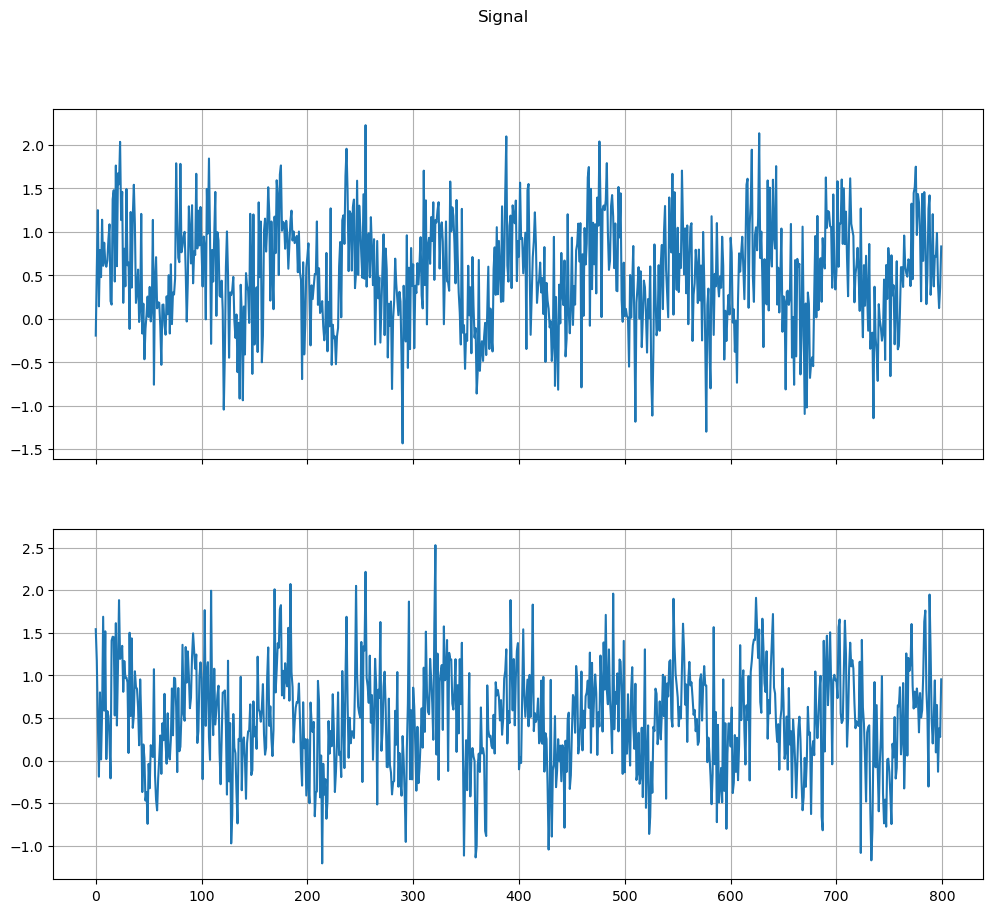

In [100]:
affichage_data(data_echantillon, seq_len, nb_channels=nb_channels)

# Boucle d'entraînement

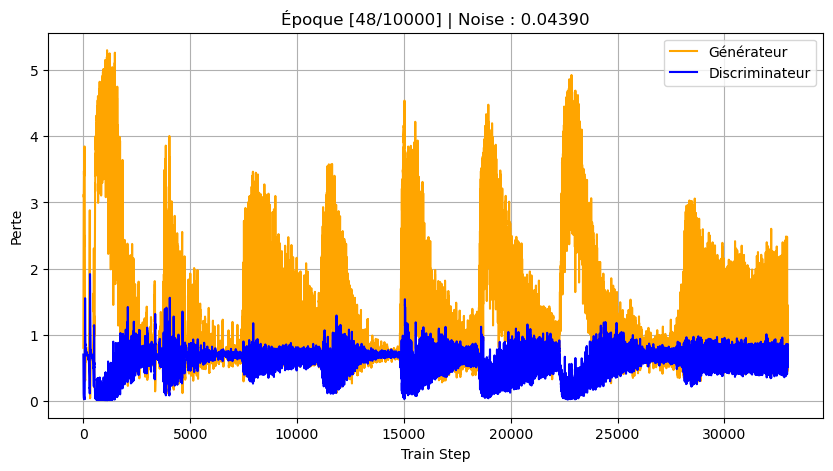

KeyboardInterrupt: 

In [113]:
for epoch in range(num_epochs):

    for i in range(num_batches):
        start_idx = i * batch_size
        end_idx = start_idx + batch_size

        # Génération des données réelles avec bruit
        real_inputs = data_echantillon[start_idx:end_idx]
        real_inputs = torch.tensor(real_inputs, dtype=torch.float32).to(device)

        # Génération des données factices
        z = torch.randn(batch_size, latent_dim).to(device)
        fake_inputs = generator(z)

        # Entraînement du discriminateur
        optimizer_D.zero_grad()
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        output_real = discriminator(real_inputs)
        loss_real = criterion(output_real, real_labels)

        output_fake = discriminator(fake_inputs.detach())
        loss_fake = criterion(output_fake, fake_labels)

        loss_D = (loss_real + loss_fake) / 2
        loss_D.backward()
        optimizer_D.step()

        # Entraînement du générateur
        optimizer_G.zero_grad()
        fake_labels = torch.ones(batch_size, 1).to(device)  # Le générateur veut que le discriminateur pense que c'est réel
        output = discriminator(fake_inputs)
        loss_G = criterion(output, fake_labels)
        loss_G.backward()
        optimizer_G.step()

        # Stocker les pertes pour affichage
        losses_D.append(loss_D.item())
        losses_G.append(loss_G.item())

    if (epoch + 1) % 50 == 0:
        noise /= 1.3
        data_echantillon = generate_data(folder_path, seq_len, nb_channel=nb_channels, noise=noise)

    # Affichage des pertes toutes les 10 époques
    if (epoch + 1) % 2 == 0:
        clear_output(wait=True)  # Efface le contenu précédent de la cellule
        
        # Affichage des pertes
        plt.figure(figsize=(10,5))
        plt.plot(losses_G, label="Générateur", color='orange')
        plt.plot(losses_D, label="Discriminateur", color='blue')
        plt.xlabel("Train Step")
        plt.ylabel("Perte")
        plt.title(f"Époque [{epoch + 1}/{num_epochs}] | Noise : {noise:.5f}")
        plt.legend()
        plt.grid()
        plt.show()


# Test affichage

(1978, 2, 1, 800)
(1, 2, 1, 800)


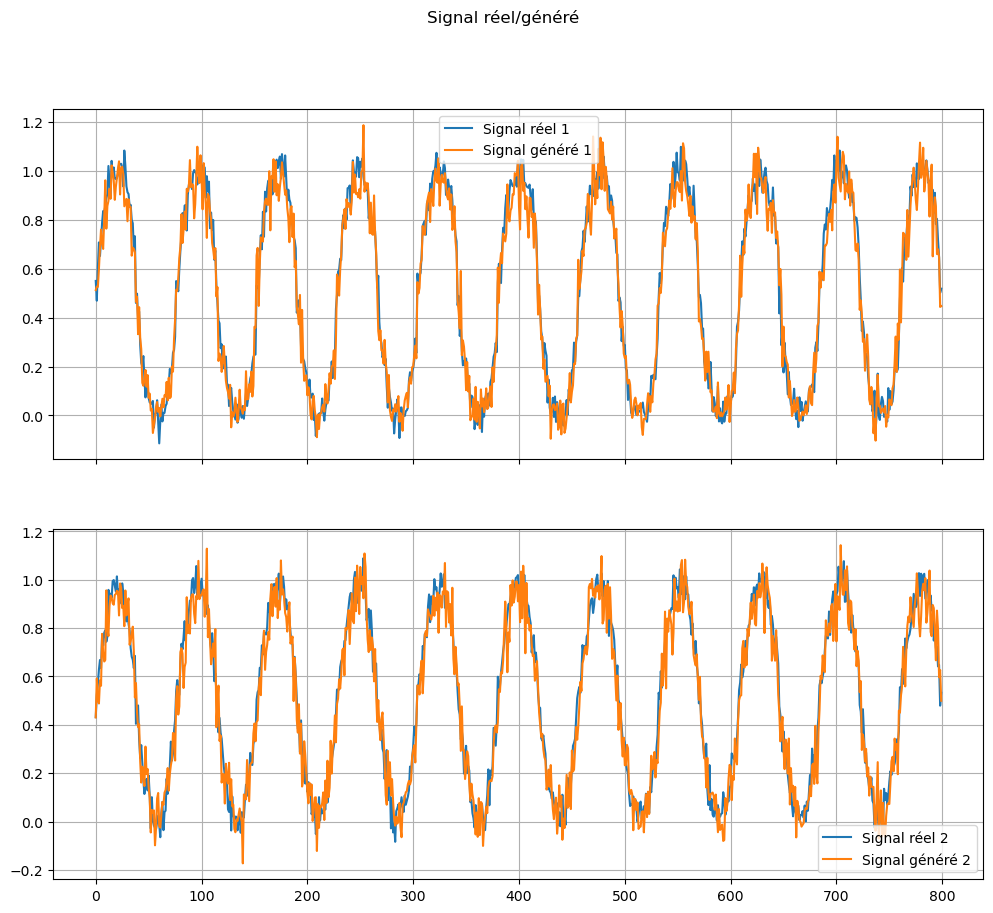

In [121]:
real_signal = data_echantillon
print(real_signal.shape)

random_index = random.randint(0, data_echantillon.shape[0])

# Génération d'un signal factice
z = torch.randn(1, latent_dim).to(device)
generated_signal = generator(z).detach().cpu().numpy()
print(generated_signal.shape)

# Diviser le plot en 5 parties
fig, axs = plt.subplots(nb_channels, 1, figsize=(12, 10), sharex=True)

# Affichage du signal réel
for i in range(nb_channels):
    axs[i].plot(real_signal[random_index][i].reshape(seq_len), label=f'Signal réel {i+1}')
    axs[i].plot(generated_signal[0][i].reshape(seq_len), label=f'Signal généré {i+1}')
    # axs[i].set_ylim(-1, 1)  # Limites de l'axe y entre -1 et 1
    axs[i].legend()
    axs[i].grid()

plt.suptitle("Signal réel/généré")
plt.show()


# Sauvegarde du modèle

In [ ]:
import os

# BEGIN: Create a directory for saving the model if it doesn't exist
save_dir = "echantillon"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
# END: Create a directory for saving the model if it doesn't exist

In [ ]:
# Sauvegarde du générateur
torch.save(generator.state_dict(), os.path.join(save_dir, 'generator.pth'))

# Sauvegarde du discriminateur
torch.save(discriminator.state_dict(), os.path.join(save_dir, 'discriminator.pth'))

print("Les modèles ont été sauvegardés avec succès.")

Les modèles ont été sauvegardés avec succès.
